In [1]:
import numpy as np 
import pandas as pd 
import numpy as np
import torch
import cv2
from PIL import Image
import albumentations as A
from torch.nn import CrossEntropyLoss
import torch.nn as nn
from skimage import io, transform
import torchvision
from albumentations.pytorch import ToTensorV2
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset, random_split
import pandas as pd
import  torch.nn.functional as F
from torch import optim
import matplotlib.pyplot as plt
from torchvision import transforms as T
from tqdm import tqdm
import os

torch.manual_seed(0)

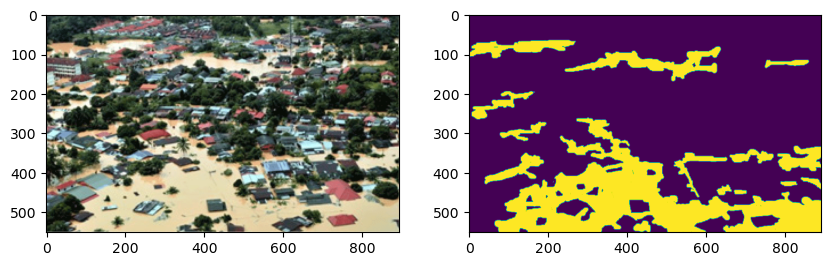

In [2]:
img = plt.imread("/kaggle/input/flood-area-segmentation/Image/0.jpg")
mask = plt.imread("/kaggle/input/flood-area-segmentation/Mask/0.png")

fig, axes = plt.subplots(1, 2, figsize=(10, 10))
axes[0].imshow(img)
axes[1].imshow(mask);

In [3]:
class FloodDataset(Dataset):
    def __init__(self, csv_file, img_dir, mask_dir, is_train=True, transform=False, channel=True):
        self.img_dir  = img_dir
        self.df = pd.read_csv(csv_file).iloc[1:, :]
        self.mask_dir = mask_dir
        self.channel = channel
        self.transform  = transform
#         self.augments = Augments
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.df.iloc[:, 0], self.df.iloc[:, 1], train_size=0.8)
        if is_train:
            self.images = self.X_train
            self.mask = self.y_train
        else:
            self.images = self.X_test
            self.mask = self.y_test
    def __len__(self):
        return len(self.images)
    def __getitem__(self, index):
        imgpath = os.path.join(self.img_dir, self.images.iloc[index])
        img    = cv2.imread(imgpath)
        mask   = cv2.imread(os.path.join(self.mask_dir, self.mask.iloc[index]))
        img, mask = cv2.cvtColor(img, cv2.COLOR_BGR2RGB), cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
        if self.transform:
            img = self.transform(img)
            mask = self.transform(mask)
        return imgpath, T.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)) (img),(mask)
    
    
img_dir = "/kaggle/input/flood-area-segmentation/Image"
mask_dir = "/kaggle/input/flood-area-segmentation/Mask"
csv = "/kaggle/input/flood-area-segmentation/metadata.csv"

IMG_SIZE = 256
batch_size = 6
device = "cuda" if torch.cuda.is_available() else "cpu"

def Otsu(img):
    mean = img.mean()
    img[img<= mean] = 0
    img[img> mean] = 1
    return img


train_transforms = T.Compose([
    T.ToTensor(),
    T.Resize((IMG_SIZE, IMG_SIZE)),
    T.RandomCrop((IMG_SIZE, IMG_SIZE)),
    T.ColorJitter(),
    T.GaussianBlur(3),
#     T.RandomVerticalFlip(),
#     T.RandomHorizontalFlip(),
#     Otsu
    
]
)
valid_transforms = T.Compose([
    T.ToTensor(),
    T.Resize((IMG_SIZE, IMG_SIZE)),
    T.RandomCrop((IMG_SIZE, IMG_SIZE)),
    T.ColorJitter(),
#     T.GaussianBlur(3),
#     T.RandomAutocontrast(),
#     T.RandomResizedCrop((256, 256))
#     Otsu
]
)


train_ds = FloodDataset(csv, img_dir, mask_dir, is_train=True,  transform=train_transforms)
test_ds = FloodDataset(csv, img_dir, mask_dir, is_train=False, transform=valid_transforms)

train_dl = DataLoader(train_ds, batch_size = batch_size,shuffle=True, pin_memory=True)
test_dl = DataLoader(test_ds, batch_size= batch_size, shuffle=True, pin_memory=True)

for _, img, mask in train_dl:
    print(_, img.shape, mask.shape)
    break

('/kaggle/input/flood-area-segmentation/Image/2043.jpg', '/kaggle/input/flood-area-segmentation/Image/7.jpg', '/kaggle/input/flood-area-segmentation/Image/1027.jpg', '/kaggle/input/flood-area-segmentation/Image/2052.jpg', '/kaggle/input/flood-area-segmentation/Image/1040.jpg', '/kaggle/input/flood-area-segmentation/Image/2007.jpg') torch.Size([6, 3, 256, 256]) torch.Size([6, 1, 256, 256])


In [4]:
len(test_ds), len(train_ds)

(58, 231)

## Image processing and utility functions

torch.Size([6, 3, 256, 256]) torch.Size([6, 1, 256, 256])


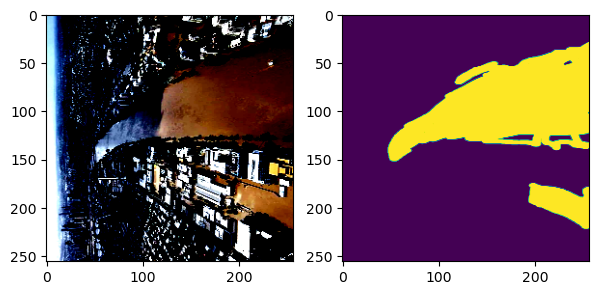

In [5]:
for _, img, mask in test_dl:
    print(img.shape, mask.shape)
    break 
fig, axis = plt.subplots(1, 2, figsize=(7, 10))
axis[0].imshow(img[0].detach().numpy().swapaxes(0, 2))
axis[1].imshow(mask[0].detach().numpy().swapaxes(0, 2))

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DiceLoss(nn.Module):
    def __init__(self, smooth=1e-6):
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, inputs, targets):
        intersection = torch.sum(inputs * targets)
        union = torch.sum(inputs) + torch.sum(targets)
        dice_score = (2.0 * intersection + self.smooth) / (union + self.smooth)
        dice_loss = 1.0 - dice_score

        return dice_loss

In [7]:
def get_best_model(model, is_SD = True):
    model_name = model.__class__.__name__
    models = []
    accs = []
    for f in os.listdir():
        if model_name in f and f.endswith(".pth"):
            models.append(f)
            acc = f.split("_")[1].split(".")[1]
            accs.append(acc)
    model = torch.load(models.pop(np.argmax(accs)))
    for i in models:
        os.remove(i)
    return model

# vit_best = get_best_model(vit)

In [8]:
import torch

def iou_score(outputs, targets, smooth=1e-4):
    intersection = torch.sum(outputs * targets)
    union = torch.sum(outputs) + torch.sum(targets) - intersection
    iou = (intersection + smooth) / (union + smooth)
    return iou


# Defining the training and validation function and initializing parameters

In [9]:
num_epochs = 30
accuracies = {}
lr = 0.001
device = "cuda" if torch.cuda.is_available() else "cpu"
# loss_fn = nn.BCEWithLogitsLoss()
loss_fn = DiceLoss()
def iou_loss(yhat, y):
    return - iou(yhat, y)
# iou_loss = lambda y, yhat: 1 - iou(y, yhat)
iou = iou_score
# iou = calculate_iou
trainSteps = int(len(train_ds)/batch_size) 
testSteps = int(len(test_ds)/batch_size) 

In [10]:
def train_model(model, traindl, testdl, loss_fn, epochs, learning_rate):
    model_name = model.__class__.__name__
    train_loss = []
    test_loss = []
    test_iou = []
    train_iou = []

    opt = optim.Adam(model.parameters(), lr = learning_rate)
    loss_fn = loss_fn
    prev_test_loss = 100
    prev_train_loss = 100
    patience = 2
    trigger_times = 0
    model = model.to(device)
    best_val_loss = 1000
    try:
        for epoch in range(1, epochs+1):
            # Training loop
            model.train(True)
            correct = 0
            totalTrainLoss ,totalTestLoss, totalTrainIou, totalTestIou = 0, 0, 0, 0

            for _, X, y in tqdm(train_dl):  
                X, y = X.to(device), y.to(device) 
                opt.zero_grad()
                yhat = model(X) 
                # loss = (1- iou(y, yhat))
        #         loss = loss_fn(y, yhat) * 0.4 + (1-iou(y, yhat))*0.6
                loss = loss_fn(yhat, y)
                iou_score = iou(yhat, y)
                totalTrainIou += iou_score.item()
                totalTrainLoss += loss.item()
                loss.backward()
                opt.step() 
            avg_iou = totalTrainIou / trainSteps
            avg_loss = (totalTrainLoss/trainSteps)
            train_iou.append(avg_iou)
            train_loss.append(avg_loss)

            # Evaluation step
            model.train(False)

            with torch.no_grad():
                for _, X, y in tqdm(test_dl): 
                    X, y = X.to(device), y.to(device) 
                    yhat = model(X) 
                    loss = loss_fn(yhat, y)
                    # loss = 1 - iou(y, yhat)
        #             loss = loss_fn(y, yhat) * 0.4 + (1-iou(y, yhat))*0.6
                    iou_score = iou(yhat, y)
                    totalTestIou += iou_score.item()
                    totalTestLoss += loss.item()
                avg_iou = (totalTestIou/testSteps)
                avg_loss = (totalTestLoss/testSteps)
                if avg_loss < best_val_loss:
                    best_val_loss = avg_loss
                    torch.save(model, f"{model_name}_{round(avg_iou, 5)}.pth")
                test_loss.append(avg_loss)
                test_iou.append(avg_iou)
                print(f"Epoch:{epoch} train loss: {train_loss[-1]} \
             valid loss: {avg_loss} valid IOU: {avg_iou} ")

    except KeyboardInterrupt:
        return model, train_loss, test_loss, train_iou, test_iou
    return model, train_loss, test_loss, train_iou, test_iou

# Image thresholding

In [10]:
img = cv2.imread(r"/kaggle/input/flood-area-segmentation/Mask/1006.png")
mask = cv2.imread(r"/kaggle/input/flood-area-segmentation/Mask/1006.png")
otsu = 0
for f in os.listdir(r"/kaggle/input/flood-area-segmentation/Image"):
    try:
        img = plt.imread(os.path.join(r"/kaggle/input/flood-area-segmentation/Image", f))[:, :, :3]
        print(img.shape)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        otsu_threshold, image_result = cv2.threshold(
        img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU,
        )
        otsu += otsu_threshold
    except Exception:
        continue

(442, 600, 3)
(682, 1024, 3)
(272, 408, 3)
(440, 660, 3)
(3644, 4859, 3)
(3333, 5000, 3)
(540, 960, 3)
(650, 976, 3)
(400, 620, 3)
(575, 862, 3)
(671, 1020, 3)
(563, 1000, 3)
(2141, 3500, 3)
(400, 600, 3)
(1800, 1800, 3)
(565, 1000, 3)
(432, 768, 3)
(1400, 2100, 3)
(449, 800, 3)
(408, 612, 3)
(540, 960, 3)
(800, 1200, 3)
(800, 1200, 3)
(561, 1000, 3)
(432, 768, 3)
(312, 600, 3)
(682, 1024, 3)
(389, 700, 3)
(408, 612, 3)
(523, 929, 3)
(900, 1200, 3)
(341, 512, 3)
(682, 1024, 3)
(450, 800, 3)
(464, 620, 3)
(523, 929, 3)
(433, 770, 3)
(720, 1280, 3)
(547, 975, 3)
(360, 480, 3)
(607, 1024, 3)
(576, 1024, 3)
(800, 1200, 3)
(900, 1200, 3)
(551, 893, 3)
(950, 634, 3)
(821, 1232, 3)
(641, 1200, 3)
(583, 875, 3)
(408, 612, 3)
(300, 357, 3)
(543, 724, 3)
(350, 595, 3)
(781, 1699, 3)
(715, 936, 3)
(675, 1200, 3)
(355, 630, 3)
(449, 800, 3)
(400, 700, 3)
(2242, 3992, 3)
(1125, 2000, 3)
(440, 604, 3)
(608, 1080, 3)
(250, 450, 3)
(1500, 2000, 3)
(3456, 5184, 3)
(675, 900, 3)
(338, 600, 3)
(749, 1200

# UNet

In [11]:
import torch
import torch.nn as nn

class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1, features=[64, 128, 256, 512]):
        super(UNet, self).__init__()

        # Contracting Path
        self.downs = nn.ModuleList()
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

        # Bottleneck
        self.bottleneck = DoubleConv(features[-1], features[-1]*2)

        # Expansive Path
        self.ups = nn.ModuleList()
        for feature in reversed(features):
            self.ups.append(
                nn.ConvTranspose2d(
                    feature*2,
                    feature,
                    kernel_size=2,
                    stride=2
                )
            )
            self.ups.append(DoubleConv(feature*2, feature))

        # Output Layer
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []

        # Contracting Path
        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = nn.functional.max_pool2d(x, kernel_size=2, stride=2)

        # Bottleneck
        x = self.bottleneck(x)

        # Expansive Path
        for i in range(0, len(self.ups), 2):
            x = self.ups[i](x)
            skip_connection = skip_connections.pop()
            x = torch.cat((x, skip_connection), dim=1)
            x = self.ups[i+1](x)

        # Output Layer
        x = nn.Sigmoid()(self.final_conv(x))
        return x

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)
unet = UNet()

### Training UNet

In [13]:
unet, train_loss, test_loss, train_iou, test_iou = train_model(unet, train_dl,
                                    test_dl, epochs=num_epochs, loss_fn = loss_fn, learning_rate=0.001)
accuracies["UNet"] = np.max(test_iou)

100%|██████████| 10/10 [00:04<00:00,  2.26it/s]


Epoch:1 train loss: 0.3234960828956805              valid loss: 0.24771690368652344 valid IOU: 0.7095196313328214 


100%|██████████| 10/10 [00:03<00:00,  2.51it/s]


Epoch:2 train loss: 0.2625330655198348              valid loss: 0.255791081322564 valid IOU: 0.7001973158783383 


100%|██████████| 10/10 [00:03<00:00,  2.58it/s]


Epoch:3 train loss: 0.25388519544350474              valid loss: 0.23877769708633423 valid IOU: 0.7200716071658664 


100%|██████████| 10/10 [00:03<00:00,  2.51it/s]


Epoch:4 train loss: 0.24195572263316104              valid loss: 0.25960692432191634 valid IOU: 0.6956652104854584 


100%|██████████| 10/10 [00:03<00:00,  2.55it/s]


Epoch:5 train loss: 0.23655957767837926              valid loss: 0.25377221902211505 valid IOU: 0.7026627527342902 


100%|██████████| 10/10 [00:03<00:00,  2.57it/s]


Epoch:6 train loss: 0.22339995754392525              valid loss: 0.20254076851738823 valid IOU: 0.7735236949390836 


100%|██████████| 10/10 [00:03<00:00,  2.55it/s]


Epoch:7 train loss: 0.22793387582427577              valid loss: 0.19297542836931017 valid IOU: 0.7866558101442125 


100%|██████████| 10/10 [00:04<00:00,  2.45it/s]


Epoch:8 train loss: 0.21401691123058922              valid loss: 0.19099140167236328 valid IOU: 0.7922708325915866 


100%|██████████| 10/10 [00:03<00:00,  2.61it/s]


Epoch:9 train loss: 0.2155333365264692              valid loss: 0.21231177780363295 valid IOU: 0.757748027642568 


100%|██████████| 10/10 [00:03<00:00,  2.58it/s]


Epoch:10 train loss: 0.2117731539826644              valid loss: 0.18219947814941406 valid IOU: 0.8025427659352621 


100%|██████████| 10/10 [00:04<00:00,  2.38it/s]


Epoch:11 train loss: 0.21082732708830582              valid loss: 0.16490989261203343 valid IOU: 0.8265521923700968 


100%|██████████| 10/10 [00:04<00:00,  2.49it/s]


Epoch:12 train loss: 0.20919722318649292              valid loss: 0.21267279651429918 valid IOU: 0.7583693928188748 


100%|██████████| 10/10 [00:04<00:00,  2.45it/s]


Epoch:13 train loss: 0.21547064341996847              valid loss: 0.2647446062829759 valid IOU: 0.690882404645284 


100%|██████████| 10/10 [00:03<00:00,  2.50it/s]


Epoch:14 train loss: 0.20446900631252088              valid loss: 0.16021068890889487 valid IOU: 0.8327998055352105 


100%|██████████| 10/10 [00:04<00:00,  2.49it/s]


Epoch:15 train loss: 0.21296379911272148              valid loss: 0.1714517076810201 valid IOU: 0.8165790173742506 


100%|██████████| 10/10 [00:03<00:00,  2.53it/s]


Epoch:16 train loss: 0.2034635183058287              valid loss: 0.22741466098361546 valid IOU: 0.7396689388487074 


100%|██████████| 10/10 [00:03<00:00,  2.51it/s]


Epoch:17 train loss: 0.19463977531382912              valid loss: 0.16232926315731472 valid IOU: 0.8310476144154867 


100%|██████████| 10/10 [00:04<00:00,  2.32it/s]


Epoch:18 train loss: 0.17352400327983655              valid loss: 0.16180121236377293 valid IOU: 0.8310734629631042 


100%|██████████| 10/10 [00:04<00:00,  2.39it/s]


Epoch:19 train loss: 0.17953770097933316              valid loss: 0.1630081401930915 valid IOU: 0.8295887576209174 


100%|██████████| 10/10 [00:04<00:00,  2.49it/s]


Epoch:20 train loss: 0.1845835290457073              valid loss: 0.1893461611535814 valid IOU: 0.7927486035558913 


100%|██████████| 10/10 [00:04<00:00,  2.41it/s]


Epoch:21 train loss: 0.18434082206926847              valid loss: 0.1500492493311564 valid IOU: 0.8481374780337015 


100%|██████████| 10/10 [00:03<00:00,  2.50it/s]


Epoch:22 train loss: 0.16645574255993492              valid loss: 0.15440905094146729 valid IOU: 0.8439575433731079 


100%|██████████| 10/10 [00:03<00:00,  2.51it/s]


Epoch:23 train loss: 0.1653776780555123              valid loss: 0.14300641086366442 valid IOU: 0.8595108787218729 


100%|██████████| 10/10 [00:04<00:00,  2.49it/s]


Epoch:24 train loss: 0.17186366100060313              valid loss: 0.14513205157385933 valid IOU: 0.8565449847115411 


100%|██████████| 10/10 [00:03<00:00,  2.52it/s]


Epoch:25 train loss: 0.17055685896622508              valid loss: 0.14586283100975883 valid IOU: 0.8563580579227872 


100%|██████████| 10/10 [00:04<00:00,  2.49it/s]


Epoch:26 train loss: 0.16477748124223007              valid loss: 0.18760784467061362 valid IOU: 0.7982518474260966 


100%|██████████| 10/10 [00:03<00:00,  2.56it/s]


Epoch:27 train loss: 0.17760173897994191              valid loss: 0.14887379275427925 valid IOU: 0.8526123563448588 


100%|██████████| 10/10 [00:04<00:00,  2.31it/s]


Epoch:28 train loss: 0.17839164169211136              valid loss: 0.16294669442706639 valid IOU: 0.8306931124793159 


100%|██████████| 10/10 [00:03<00:00,  2.52it/s]


Epoch:29 train loss: 0.17819875792453163              valid loss: 0.16333681344985962 valid IOU: 0.8305230736732483 


100%|██████████| 10/10 [00:03<00:00,  2.57it/s]

Epoch:30 train loss: 0.17479114312874644              valid loss: 0.1743929386138916 valid IOU: 0.8112915092044406 


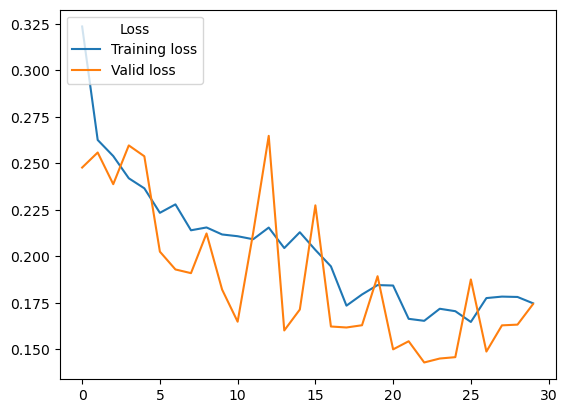

In [14]:
plt.plot(train_loss,label='Training loss')
plt.plot(test_loss, label='Valid loss')
plt.legend(loc='upper left', title='Loss');

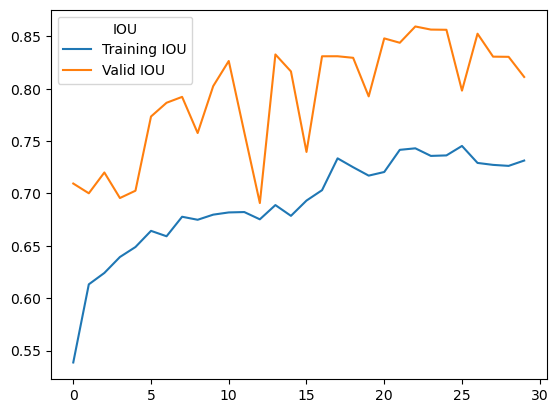

In [15]:
plt.plot(train_iou,label='Training IOU')
plt.plot(test_iou, label='Valid IOU')
plt.legend(loc='upper left', title='IOU');

In [16]:
unet = get_best_model(unet)

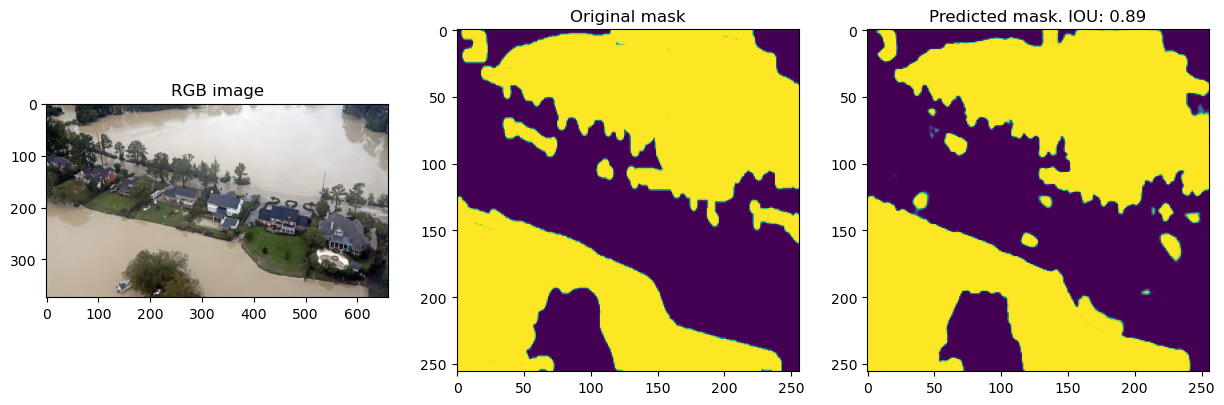

In [17]:
for impath, img, mask in test_dl:
    break
res = unet(img.to(device))
fig, axis = plt.subplots(1, 3, figsize=(15, 17))
orgimg = plt.imread(impath[0])
axis[0].imshow( orgimg)
axis[0].set_title("RGB image")
axis[1].imshow(mask[0].detach().cpu().permute(1, 2,0) )
axis[1].set_title("Original mask")
axis[2].imshow(res[0].detach().cpu().permute(1, 2, 0))
axis[2].set_title(f"Predicted mask. IOU: {round(float(iou(res[0], mask[0].to(device))), 3)}")
# print(res[0].min(), res[0].max(), (mask[0]).min(), (mask[0]).max())
plt.show()

# U2net

In [14]:
class Squeeze_Excite(nn.Module):
    
    def __init__(self,channel,reduction):
        super().__init__()
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channel, channel // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channel // reduction, channel, bias=False),
            nn.Sigmoid()
        )
    
    def forward(self,x):
        b, c, _, _ = x.size()
        y = self.avgpool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)
class VGGBlock(nn.Module):
    
    def __init__(self, in_channels, middle_channels, out_channels):
        super().__init__()
        self.relu = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv2d(in_channels, middle_channels, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(middle_channels)
        self.conv2 = nn.Conv2d(middle_channels, out_channels, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.SE = Squeeze_Excite(out_channels,8)
    
    def forward(self,x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)
        out = self.SE(out)
        
        return(out)
def output_block():
    Layer = nn.Sequential(nn.Conv2d(in_channels=32, out_channels=1, kernel_size=(1,1)),
                 nn.Sigmoid())
    return Layer
class DUNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = VGGBlock(3,64,64)        
        self.conv2 = VGGBlock(64,128,128)
        self.conv3 = VGGBlock(128,256,256)
        self.conv4 = VGGBlock(256,512,512)
        self.conv5 = VGGBlock(512,512,512)
        
        self.pool = nn.MaxPool2d(2, 2)
        self.up = nn.Upsample(scale_factor=2, mode='bilinear')
        
        self.Vgg1 = VGGBlock(1024,256,256)
        self.Vgg2 = VGGBlock(512,128,128)
        self.Vgg3 = VGGBlock(256,64,64)
        self.Vgg4 = VGGBlock(128,32,32)
        
        self.out = output_block()
        
        self.conv11 = VGGBlock(6,32,32)
        self.conv12 = VGGBlock(32,64,64)
        self.conv13 = VGGBlock(64,128,128)
        self.conv14 = VGGBlock(128,256,256)
        
        self.Vgg5 = VGGBlock(1024,256,256)
        self.Vgg6 = VGGBlock(640,128,128)
        self.Vgg7 = VGGBlock(320,64,64)
        self.Vgg8 = VGGBlock(160,32,32)
        
        self.out1 = nn.Conv2d(in_channels=32, out_channels=1, kernel_size=(1,1))
    
    def forward(self,x):
        x1 = self.conv1(x)
                
        x2 = self.conv2(self.pool(x1))
        x3 = self.conv3(self.pool(x2))
        x4 = self.conv4(self.pool(x3))
        x5 = self.conv5(self.pool(x4))        
        
        x5 = self.up(x5)
        x5 = torch.cat([x5,x4],1)
        x6 = self.Vgg1(x5)
        
        x6 = self.up(x6)
        x6 = torch.cat([x6,x3],1)  
        x7 = self.Vgg2(x6)
                
        x7 = self.up(x7)
        x7 = torch.cat([x7,x2],1)  
        x8 = self.Vgg3(x7)
                
        x8 = self.up(x8)
        x8 = torch.cat([x8,x1],1)  
        x9 = self.Vgg4(x8)
                
        output1 = self.out(x9)
        output1 = x*output1
        
        x = torch.cat([x,output1],1)
        
        x11 = self.conv11(x)
                
        x12 = self.conv12(self.pool(x11))
        x13 = self.conv13(self.pool(x12))
        x14 = self.conv14(self.pool(x13))        
                
        y = self.pool(x14)
        
        y = self.up(y)
        y = torch.cat([y,x14,x4],1)
        y = self.Vgg5(y)
                
        y = self.up(y)
        y = torch.cat([y,x13,x3],1)
        y = self.Vgg6(y)
               
        y = self.up(y)
        y = torch.cat([y,x12,x2],1)
        y = self.Vgg7(y)
                
        y = self.up(y)
        y = torch.cat([y,x11,x1],1)
        y = self.Vgg8(y)
        
        output2 = self.out1(y)
        # print(output2.size())
        return torch.sigmoid(output2)
u2net = DUNet()

In [15]:
u2net, train_loss, test_loss, train_iou, test_iou = train_model(u2net, train_dl,
                                    test_dl, epochs=num_epochs, loss_fn = loss_fn, learning_rate=0.001)
accuracies["U2Net"] = np.max(test_iou)

100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


Epoch:1 train loss: 0.41550299368406596              valid loss: 0.44173052575853133 valid IOU: 0.4801507492860158 


100%|██████████| 10/10 [00:02<00:00,  3.48it/s]


Epoch:2 train loss: 0.33677749727901657              valid loss: 0.3895433213975694 valid IOU: 0.5350446436140273 


100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


Epoch:3 train loss: 0.2882597618981412              valid loss: 0.37846483786900836 valid IOU: 0.5559036433696747 


100%|██████████| 10/10 [00:02<00:00,  3.42it/s]


Epoch:4 train loss: 0.25952772247163874              valid loss: 0.2957328160603841 valid IOU: 0.6491128835413191 


100%|██████████| 10/10 [00:02<00:00,  3.44it/s]


Epoch:5 train loss: 0.21825896595653735              valid loss: 0.24172896146774292 valid IOU: 0.7184301879670885 


100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


Epoch:6 train loss: 0.20543559758286728              valid loss: 0.21524631314807469 valid IOU: 0.7541079719861349 


100%|██████████| 10/10 [00:02<00:00,  3.41it/s]


Epoch:7 train loss: 0.19435653561039976              valid loss: 0.21605304876963297 valid IOU: 0.7534739772478739 


100%|██████████| 10/10 [00:02<00:00,  3.42it/s]


Epoch:8 train loss: 0.19410386681556702              valid loss: 0.24349157677756417 valid IOU: 0.7161011728975508 


100%|██████████| 10/10 [00:02<00:00,  3.47it/s]


Epoch:9 train loss: 0.18247954625832408              valid loss: 0.25660961866378784 valid IOU: 0.6994680033789741 


100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


Epoch:10 train loss: 0.19919902243112264              valid loss: 0.22695164548026192 valid IOU: 0.7373514903916253 


100%|██████████| 10/10 [00:03<00:00,  3.02it/s]


Epoch:11 train loss: 0.17738687364678635              valid loss: 0.17152465052074856 valid IOU: 0.8165673812230428 


100%|██████████| 10/10 [00:02<00:00,  3.42it/s]


Epoch:12 train loss: 0.18224198253531204              valid loss: 0.2105956276257833 valid IOU: 0.7619477179315355 


100%|██████████| 10/10 [00:02<00:00,  3.42it/s]


Epoch:13 train loss: 0.1796462927993975              valid loss: 0.2221542927953932 valid IOU: 0.7432665228843689 


100%|██████████| 10/10 [00:02<00:00,  3.46it/s]


Epoch:14 train loss: 0.18047188771398445              valid loss: 0.19549239344067043 valid IOU: 0.7821371091736687 


100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


Epoch:15 train loss: 0.18302894893445468              valid loss: 0.17589326037300956 valid IOU: 0.8090747462378608 


100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


Epoch:16 train loss: 0.17146597881066172              valid loss: 0.19882994890213013 valid IOU: 0.7788456413480971 


100%|██████████| 10/10 [00:02<00:00,  3.44it/s]


Epoch:17 train loss: 0.1616126189106389              valid loss: 0.15791587034861246 valid IOU: 0.8353791369332207 


100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


Epoch:18 train loss: 0.1539472498391804              valid loss: 0.20424309704038832 valid IOU: 0.7688404520352682 


100%|██████████| 10/10 [00:02<00:00,  3.38it/s]


Epoch:19 train loss: 0.15684682444522255              valid loss: 0.15618443489074707 valid IOU: 0.8395889004071554 


100%|██████████| 10/10 [00:02<00:00,  3.47it/s]


Epoch:20 train loss: 0.15121551407010933              valid loss: 0.15684641732109916 valid IOU: 0.8378658228450351 


100%|██████████| 10/10 [00:03<00:00,  3.00it/s]


Epoch:21 train loss: 0.16139979895792508              valid loss: 0.16274125046200222 valid IOU: 0.8278296457396613 


100%|██████████| 10/10 [00:02<00:00,  3.40it/s]


Epoch:22 train loss: 0.14802959247639305              valid loss: 0.16106571091545951 valid IOU: 0.8314801918135749 


100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


Epoch:23 train loss: 0.1547560487922869              valid loss: 0.1691280404726664 valid IOU: 0.8205876416630216 


100%|██████████| 10/10 [00:02<00:00,  3.46it/s]


Epoch:24 train loss: 0.15659968633400767              valid loss: 0.1634040011299981 valid IOU: 0.8281431065665351 


100%|██████████| 10/10 [00:02<00:00,  3.50it/s]


Epoch:25 train loss: 0.15661196959646126              valid loss: 0.15215062432818943 valid IOU: 0.844698084725274 


100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


Epoch:26 train loss: 0.1577086213387941              valid loss: 0.1604801615079244 valid IOU: 0.8328793777359856 


100%|██████████| 10/10 [00:02<00:00,  3.48it/s]


Epoch:27 train loss: 0.1499755633504767              valid loss: 0.15428872240914238 valid IOU: 0.8416728244887458 


100%|██████████| 10/10 [00:03<00:00,  3.32it/s]


Epoch:28 train loss: 0.15421091882806076              valid loss: 0.162785099612342 valid IOU: 0.8289142184787326 


100%|██████████| 10/10 [00:02<00:00,  3.47it/s]


Epoch:29 train loss: 0.1468708060289684              valid loss: 0.1509170797136095 valid IOU: 0.8465994397799174 


100%|██████████| 10/10 [00:02<00:00,  3.39it/s]

Epoch:30 train loss: 0.14775410608241432              valid loss: 0.15179204278522068 valid IOU: 0.8459275099966261 


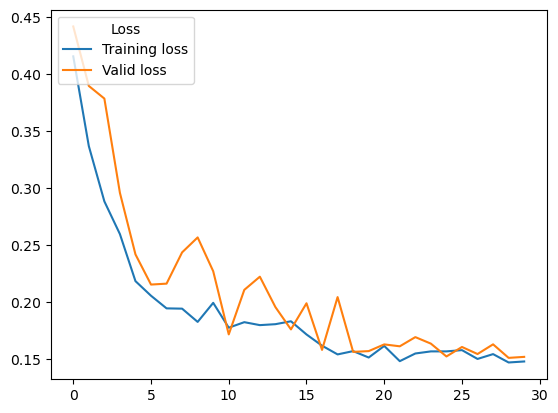

In [16]:
plt.plot(train_loss,label='Training loss')
plt.plot(test_loss, label='Valid loss')
plt.legend(loc='upper left', title='Loss');

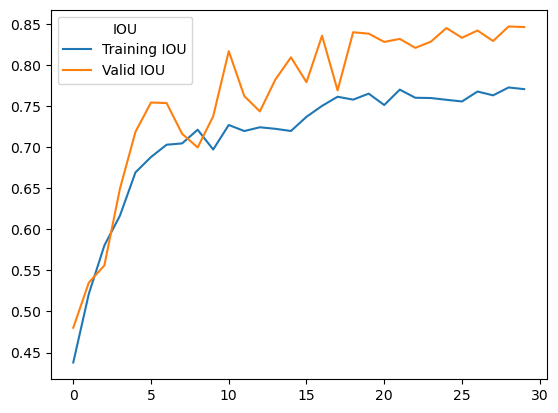

In [17]:
plt.plot(train_iou,label='Training IOU')
plt.plot(test_iou, label='Valid IOU')
plt.legend(loc='upper left', title='IOU');

In [19]:
u2net = get_best_model(u2net)

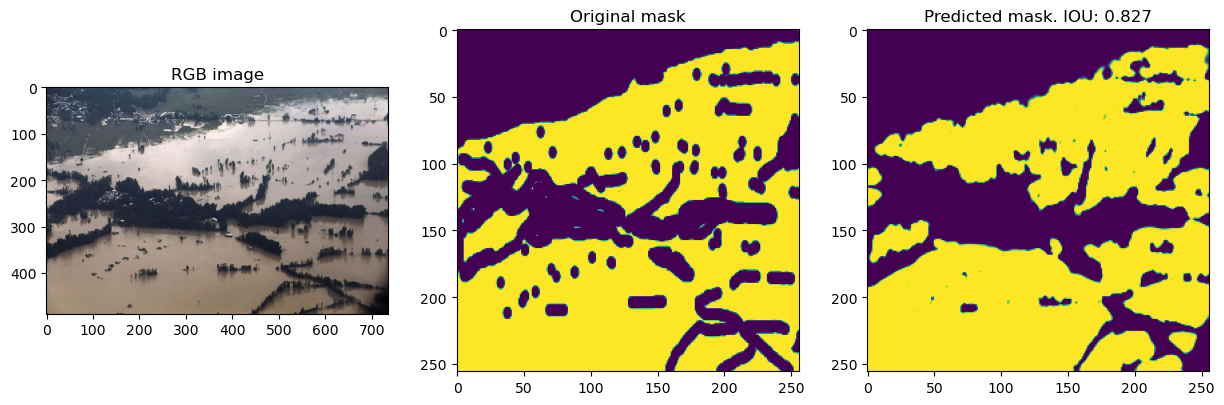

In [23]:
for impath, img, mask in test_dl:
    break
res = u2net(img.to(device))
fig, axis = plt.subplots(1, 3, figsize=(15, 17))
orgimg = plt.imread(impath[0])
axis[0].imshow( orgimg)
axis[0].set_title("RGB image")
axis[1].imshow(mask[0].detach().cpu().permute(1, 2,0) )
axis[1].set_title("Original mask")
axis[2].imshow(res[0].detach().cpu().permute(1, 2, 0))
axis[2].set_title(f"Predicted mask. IOU: {round(float(iou(res[0], mask[0].to(device))), 3)}")
# print(res[0].min(), res[0].max(), (mask[0]).min(), (mask[0]).max())
plt.show()

## ResNextUNet

In [58]:
import torch
from torch import nn
from torchvision.models import resnext50_32x4d

class ConvRelu(nn.Module):
    def __init__(self, in_channels, out_channels, kernel, padding):
        super().__init__()

        self.convrelu = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel, padding=padding),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.convrelu(x)
        return x

class DecoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        
        self.conv1 = ConvRelu(in_channels, in_channels // 4, 1, 0)
        
        self.deconv = nn.ConvTranspose2d(in_channels // 4, in_channels // 4, kernel_size=4,
                                          stride=2, padding=1, output_padding=0)
        
        self.conv2 = ConvRelu(in_channels // 4, out_channels, 1, 0)

    def forward(self, x):
        x = self.conv1(x)
        x = self.deconv(x)
        x = self.conv2(x)

        return x


class ResNext50Unet(nn.Module):

    def __init__(self, n_classes=1):
        super().__init__()
        
        self.base_model = resnext50_32x4d(pretrained=True)
        self.base_layers = list(self.base_model.children())
        filters = [4*64, 4*128, 4*256, 4*512]
        
        # Down
        self.encoder0 = nn.Sequential(*self.base_layers[:3])
        self.encoder1 = nn.Sequential(*self.base_layers[4])
        self.encoder2 = nn.Sequential(*self.base_layers[5])
        self.encoder3 = nn.Sequential(*self.base_layers[6])
        self.encoder4 = nn.Sequential(*self.base_layers[7])

        # Up
        self.decoder4 = DecoderBlock(filters[3], filters[2])
        self.decoder3 = DecoderBlock(filters[2], filters[1])
        self.decoder2 = DecoderBlock(filters[1], filters[0])
        self.decoder1 = DecoderBlock(filters[0], filters[0])

        # Final Classifier
        self.last_conv0 = ConvRelu(256, 128, 3, 1)
        self.last_conv1 = nn.Conv2d(128, n_classes, 3, padding=1)
        self.dropout = nn.Dropout(0.2)
                       
        
    def forward(self, x):
        # Down
        x = self.encoder0(x)
        e1 = self.encoder1(x)
        e2 = self.encoder2(e1)
        e3 = self.encoder3(e2)
        e4 = self.encoder4(e3)

        # Up + sc
#         e4 = self.dropout(e4)
        d4 = self.decoder4(e4) + e3
        d3 = self.decoder3(d4) + e2
        d2 = self.decoder2(d3) + e1
        d1 = self.decoder1(d2)

        # final classifier
#         d1 = self.dropout(d1)
        out = self.last_conv0(d1)
        out = self.last_conv1(out)
        out = nn.Sigmoid()(out)
        return out
resnextUnet = ResNext50Unet()

/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNeXt50_32X4D_Weights.IMAGENET1K_V1`. You can also use `weights=ResNeXt50_32X4D_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnext50_32x4d-7cdf4587.pth" to /root/.cache/torch/hub/checkpoints/resnext50_32x4d-7cdf4587.pth


  0%|          | 0.00/95.8M [00:00<?, ?B/s]

## Training ResNextUnet

In [59]:
resnextUnet, train_loss, test_loss, train_iou, test_iou = train_model(resnextUnet, train_dl,
                                    test_dl, epochs=num_epochs, loss_fn = loss_fn, learning_rate=0.001)
accuracies["ResNextUNet"] = max(test_iou)

100%|██████████| 10/10 [00:06<00:00,  1.48it/s]


Epoch:1 train loss: 0.35484189422507034              valid loss: 0.4633127318488227 valid IOU: 0.4629221393002404 


100%|██████████| 10/10 [00:06<00:00,  1.55it/s]


Epoch:2 train loss: 0.2291887967210067              valid loss: 0.17050680187013414 valid IOU: 0.8184772266281976 


100%|██████████| 10/10 [00:06<00:00,  1.53it/s]


Epoch:3 train loss: 0.18847331404685974              valid loss: 0.18908718559477064 valid IOU: 0.7997976276609633 


100%|██████████| 10/10 [00:06<00:00,  1.46it/s]


Epoch:4 train loss: 0.18063059292341532              valid loss: 0.19083723757002088 valid IOU: 0.7927746077378591 


100%|██████████| 10/10 [00:06<00:00,  1.53it/s]


Epoch:5 train loss: 0.17371763367401927              valid loss: 0.14577548371420967 valid IOU: 0.8559178180164762 


100%|██████████| 10/10 [00:06<00:00,  1.55it/s]


Epoch:6 train loss: 0.16010189683813797              valid loss: 0.16250945462120903 valid IOU: 0.8309449619717069 


100%|██████████| 10/10 [00:06<00:00,  1.46it/s]


Epoch:7 train loss: 0.16912754272159777              valid loss: 0.13106408384111193 valid IOU: 0.879026386472914 


100%|██████████| 10/10 [00:06<00:00,  1.55it/s]


Epoch:8 train loss: 0.15997933714013352              valid loss: 0.17604209979375204 valid IOU: 0.8124685684839884 


100%|██████████| 10/10 [00:06<00:00,  1.52it/s]


Epoch:9 train loss: 0.1593863258236333              valid loss: 0.145337528652615 valid IOU: 0.8563883966869779 


100%|██████████| 10/10 [00:06<00:00,  1.46it/s]


Epoch:10 train loss: 0.14798142251215482              valid loss: 0.12107525931464301 valid IOU: 0.8943870464960734 


100%|██████████| 10/10 [00:07<00:00,  1.42it/s]


Epoch:11 train loss: 0.142171920914399              valid loss: 0.12321555614471436 valid IOU: 0.8908830748664008 


100%|██████████| 10/10 [00:06<00:00,  1.53it/s]


Epoch:12 train loss: 0.13723004491705643              valid loss: 0.13853703604804146 valid IOU: 0.868408825662401 


100%|██████████| 10/10 [00:06<00:00,  1.53it/s]


Epoch:13 train loss: 0.13976964825078061              valid loss: 0.11507824394438002 valid IOU: 0.9035946660571628 


100%|██████████| 10/10 [00:06<00:00,  1.56it/s]


Epoch:14 train loss: 0.13884412458068446              valid loss: 0.11700376537111071 valid IOU: 0.9013053178787231 


100%|██████████| 10/10 [00:06<00:00,  1.52it/s]


Epoch:15 train loss: 0.12914457289796127              valid loss: 0.13138090901904637 valid IOU: 0.8779821197191874 


100%|██████████| 10/10 [00:06<00:00,  1.55it/s]


Epoch:16 train loss: 0.1319241962934795              valid loss: 0.10446140501234266 valid IOU: 0.9213307897249857 


100%|██████████| 10/10 [00:06<00:00,  1.50it/s]


Epoch:17 train loss: 0.1258670311225088              valid loss: 0.11276574929555257 valid IOU: 0.9079315463701884 


100%|██████████| 10/10 [00:06<00:00,  1.54it/s]


Epoch:18 train loss: 0.1282180406545338              valid loss: 0.11863836977216932 valid IOU: 0.8991250793139139 


100%|██████████| 10/10 [00:06<00:00,  1.54it/s]


Epoch:19 train loss: 0.13147454355892382              valid loss: 0.10496567355261908 valid IOU: 0.9221113853984408 


100%|██████████| 10/10 [00:06<00:00,  1.44it/s]


Epoch:20 train loss: 0.12043272194109465              valid loss: 0.10514858033921984 valid IOU: 0.9205128881666396 


100%|██████████| 10/10 [00:06<00:00,  1.54it/s]


Epoch:21 train loss: 0.11782504069177728              valid loss: 0.09689231713612874 valid IOU: 0.9337255358695984 


100%|██████████| 10/10 [00:06<00:00,  1.54it/s]


Epoch:22 train loss: 0.11717934200638219              valid loss: 0.10419823063744439 valid IOU: 0.9220907423231337 


100%|██████████| 10/10 [00:06<00:00,  1.47it/s]


Epoch:23 train loss: 0.1083654290751407              valid loss: 0.10219630930158827 valid IOU: 0.9249094592200385 


100%|██████████| 10/10 [00:06<00:00,  1.52it/s]


Epoch:24 train loss: 0.12207720781627454              valid loss: 0.10394201676050822 valid IOU: 0.9223029149903191 


100%|██████████| 10/10 [00:06<00:00,  1.54it/s]


Epoch:25 train loss: 0.10958277394897059              valid loss: 0.09023579623964098 valid IOU: 0.9447040425406562 


100%|██████████| 10/10 [00:06<00:00,  1.50it/s]


Epoch:26 train loss: 0.10921052725691545              valid loss: 0.0898261268933614 valid IOU: 0.9455648329522874 


100%|██████████| 10/10 [00:06<00:00,  1.53it/s]


Epoch:27 train loss: 0.10947497267472117              valid loss: 0.09856314791573419 valid IOU: 0.9309732715288798 


100%|██████████| 10/10 [00:06<00:00,  1.53it/s]


Epoch:28 train loss: 0.11216820541181062              valid loss: 0.09224355883068508 valid IOU: 0.9418604903750949 


100%|██████████| 10/10 [00:06<00:00,  1.54it/s]


Epoch:29 train loss: 0.1062536569018113              valid loss: 0.09776726033952501 valid IOU: 0.933088223139445 


100%|██████████| 10/10 [00:06<00:00,  1.50it/s]


Epoch:30 train loss: 0.10573551372477882              valid loss: 0.08625702063242595 valid IOU: 0.9516877598232694 


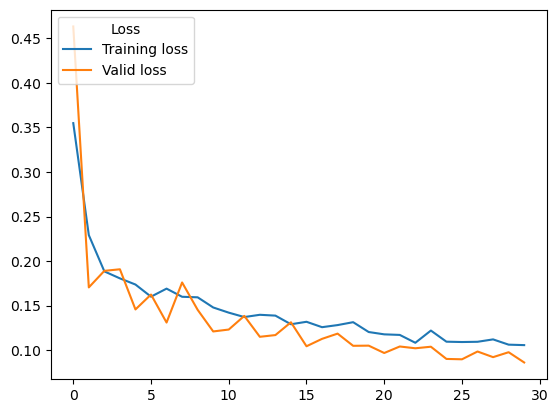

In [63]:
plt.plot(train_loss,label='Training loss')
plt.plot(test_loss, label='Valid loss')
plt.legend(loc='upper left', title='Loss');

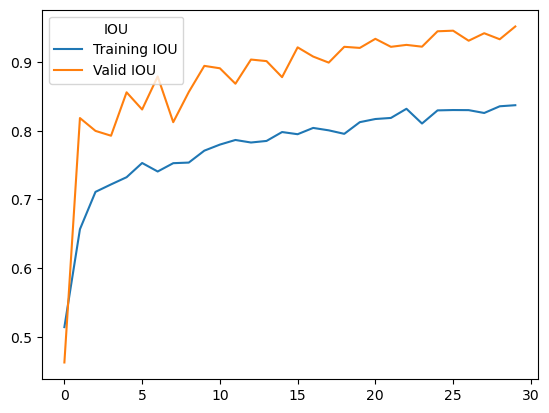

In [64]:
plt.plot(train_iou,label='Training IOU')
plt.plot(test_iou, label='Valid IOU')
plt.legend(loc='upper left', title='IOU');

In [65]:
resnextUnet=  get_best_model(resnextUnet)

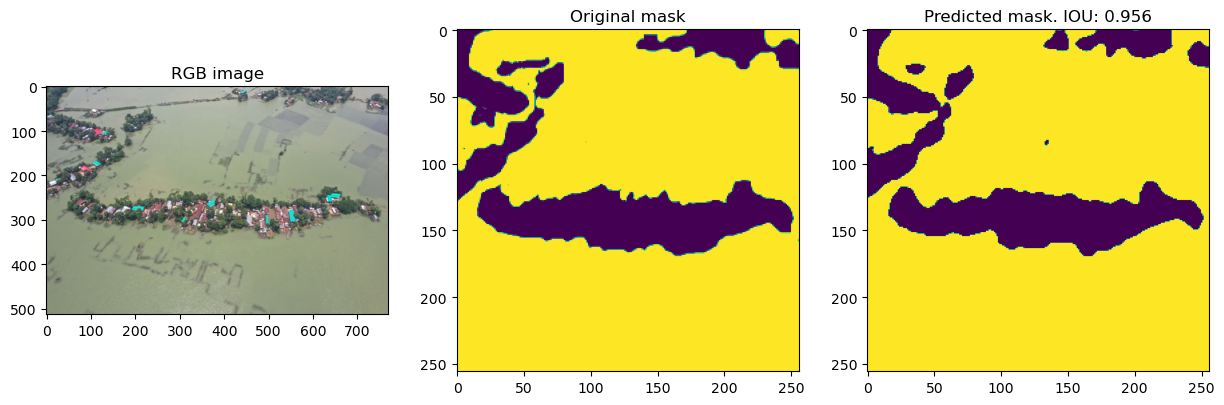

In [67]:
for impath, img, mask in test_dl:
    break
res = resnextUnet(img.to(device))
fig, axis = plt.subplots(1, 3, figsize=(15, 17))
orgimg = plt.imread(impath[0])
axis[0].imshow( orgimg)
axis[0].set_title("RGB image")
axis[1].imshow(mask[0].detach().cpu().permute(1, 2,0) )
axis[1].set_title("Original mask")
axis[2].imshow(res[0].detach().cpu().permute(1, 2, 0))
axis[2].set_title(f"Predicted mask. IOU: {round(float(iou(res[0], mask[0].to(device))), 3)}")
# print(res[0].min(), res[0].max(), (mask[0]).min(), (mask[0]).max())
plt.show()

## Comparing with DeepLabV3+, VIT


# VIT

In [12]:

def get_positional_embeddings(sequence_length, d):
    result = torch.ones(sequence_length, d)
    for i in range(sequence_length):
        for j in range(d):
            result[i][j] = np.sin(i / (10000 ** (j / d))) if j % 2 == 0 else np.cos(i / (10000 ** ((j - 1) / d)))
    return result

def patchify(images, n_patches):
    n, c, h, w = images.shape

    assert h == w, "Patchify method is implemented for square images only"

    patches = torch.zeros(n, n_patches ** 2, h * w * c // n_patches ** 2)
    patch_size = h // n_patches

    for idx, image in enumerate(images):
        for i in range(n_patches):
            for j in range(n_patches):
                patch = image[:, i * patch_size: (i + 1) * patch_size, j * patch_size: (j + 1) * patch_size]
                patches[idx, i * n_patches + j] = patch.flatten()
    return patches
class MyMSA(nn.Module):
    def __init__(self, d, n_heads=2):
        super(MyMSA, self).__init__()
        self.d = d
        self.n_heads = n_heads

        assert d % n_heads == 0, f"Can't divide dimension {d} into {n_heads} heads"

        d_head = int(d / n_heads)
        self.q_mappings = nn.ModuleList([nn.Linear(d_head, d_head) for _ in range(self.n_heads)])
        self.k_mappings = nn.ModuleList([nn.Linear(d_head, d_head) for _ in range(self.n_heads)])
        self.v_mappings = nn.ModuleList([nn.Linear(d_head, d_head) for _ in range(self.n_heads)])
        self.d_head = d_head
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, sequences):
        # Sequences has shape (N, seq_length, token_dim)
        # We go into shape    (N, seq_length, n_heads, token_dim / n_heads)
        # And come back to    (N, seq_length, item_dim)  (through concatenation)
        result = []
        for sequence in sequences:
            seq_result = []
            for head in range(self.n_heads):
                q_mapping = self.q_mappings[head]
                k_mapping = self.k_mappings[head]
                v_mapping = self.v_mappings[head]

                seq = sequence[:, head * self.d_head: (head + 1) * self.d_head]
                q, k, v = q_mapping(seq), k_mapping(seq), v_mapping(seq)

                attention = self.softmax(q @ k.T / (self.d_head ** 0.5))
                seq_result.append(attention @ v)
            result.append(torch.hstack(seq_result))
        return torch.cat([torch.unsqueeze(r, dim=0) for r in result])
class MyViTBlock(nn.Module):
    def __init__(self, hidden_d, n_heads, mlp_ratio=4):
        super(MyViTBlock, self).__init__()
        self.hidden_d = hidden_d
        self.n_heads = n_heads

        self.norm1 = nn.LayerNorm(hidden_d)
        self.mhsa = MyMSA(hidden_d, n_heads)
        self.norm2 = nn.LayerNorm(hidden_d)
        self.mlp = nn.Sequential(
            nn.Linear(hidden_d, mlp_ratio * hidden_d),
            nn.GELU(),
            nn.Linear(mlp_ratio * hidden_d, hidden_d)
        )

    def forward(self, x):
        out = x + self.mhsa(self.norm1(x))
        out = out + self.mlp(self.norm2(out))
        return out
class MyViT(nn.Module):
    def __init__(self, chw, n_patches=7, n_blocks=2, hidden_d=8, n_heads=2, out_d=10):
        # Super constructor
        super(MyViT, self).__init__()
        
        # Attributes
        self.chw = chw # ( C , H , W )
        self.n_patches = n_patches
        self.n_blocks = n_blocks
        self.n_heads = n_heads
        self.hidden_d = hidden_d
        
        # Input and patches sizes
        assert chw[1] % n_patches == 0, "Input shape not entirely divisible by number of patches"
        assert chw[2] % n_patches == 0, "Input shape not entirely divisible by number of patches"
        self.patch_size = (chw[1] / n_patches, chw[2] / n_patches)

        # 1) Linear mapper
        self.input_d = int(chw[0] * self.patch_size[0] * self.patch_size[1])
        self.linear_mapper = nn.Linear(self.input_d, self.hidden_d)
        
        # 2) Learnable classification token
        self.class_token = nn.Parameter(torch.rand(1, self.hidden_d))
        
        # 3) Positional embedding
        self.register_buffer('positional_embeddings', get_positional_embeddings(n_patches ** 2 + 1, hidden_d), persistent=False)
        
        # 4) Transformer encoder blocks
        self.blocks = nn.ModuleList([MyViTBlock(hidden_d, n_heads) for _ in range(n_blocks)])
        
        # 5) Classification MLPk
        self.mlp = nn.Sequential(
            nn.Linear(self.hidden_d, IMG_SIZE*IMG_SIZE),
        )
        # self.segment_out = nn.Conv2d(1, 1, kernel_size=3, padding = 1)


    def forward(self, images):
        # Dividing images into patches
        n, c, h, w = images.shape
        patches = patchify(images, self.n_patches).to(self.positional_embeddings.device)
        
        # Running linear layer tokenization
        # Map the vector corresponding to each patch to the hidden size dimension
        tokens = self.linear_mapper(patches)
        
        # Adding classification token to the tokens
        tokens = torch.cat((self.class_token.expand(n, 1, -1), tokens), dim=1)
        
        # Adding positional embedding
        out = tokens + self.positional_embeddings.repeat(n, 1, 1)
        
        # Transformer Blocks
        for block in self.blocks:
            out = block(out)
            
        # Getting the classification token only
        out = out[:, 0]
        out = self.mlp(out)
        mask_logits = out.view(-1, 1, IMG_SIZE, IMG_SIZE)
        
        # Apply softmax activation to generate probabilities
        mask_probs = nn.Sigmoid()(mask_logits)
        return  mask_probs
vit = MyViT((3, 256, 256), n_patches=8, n_blocks=2, hidden_d=8, n_heads=2, out_d=224*224).to(device)

## Training VIT Segmentation model

In [14]:
vit, train_loss, test_loss, train_iou, test_iou = train_model(vit, train_dl,
                                    test_dl, epochs=num_epochs, loss_fn = loss_fn, learning_rate=0.001)
accuracies["VIT"] = np.max(test_iou)

100%|██████████| 10/10 [00:04<00:00,  2.31it/s]


Epoch:1 train loss: 0.4575213538972955              valid loss: 0.49323281314637923 valid IOU: 0.433546072906918 


100%|██████████| 10/10 [00:04<00:00,  2.27it/s]


Epoch:2 train loss: 0.44748891027350174              valid loss: 0.4848819176355998 valid IOU: 0.43852002090877956 


100%|██████████| 10/10 [00:04<00:00,  2.29it/s]


Epoch:3 train loss: 0.4468918050590314              valid loss: 0.48378625843260026 valid IOU: 0.44193988376193577 


100%|██████████| 10/10 [00:04<00:00,  2.34it/s]


Epoch:4 train loss: 0.4428348243236542              valid loss: 0.47690359089109635 valid IOU: 0.4464444120724996 


100%|██████████| 10/10 [00:04<00:00,  2.32it/s]


Epoch:5 train loss: 0.4409850161326559              valid loss: 0.4840204980638292 valid IOU: 0.4383797281318241 


100%|██████████| 10/10 [00:04<00:00,  2.30it/s]


Epoch:6 train loss: 0.44279254580798905              valid loss: 0.4823930395974053 valid IOU: 0.44407955474323696 


100%|██████████| 10/10 [00:04<00:00,  2.32it/s]


Epoch:7 train loss: 0.4415115337622793              valid loss: 0.4829864700635274 valid IOU: 0.4444613390498691 


100%|██████████| 10/10 [00:04<00:00,  2.25it/s]


Epoch:8 train loss: 0.4416895791103965              valid loss: 0.4844912754164802 valid IOU: 0.44410666823387146 


100%|██████████| 10/10 [00:04<00:00,  2.14it/s]


Epoch:9 train loss: 0.4419592054266679              valid loss: 0.4807155860794915 valid IOU: 0.441816121339798 


100%|██████████| 10/10 [00:04<00:00,  2.28it/s]


Epoch:10 train loss: 0.442676737120277              valid loss: 0.4775819778442383 valid IOU: 0.4450696110725403 


100%|██████████| 10/10 [00:04<00:00,  2.25it/s]


Epoch:11 train loss: 0.4410104955497541              valid loss: 0.4769757323794895 valid IOU: 0.44934091965357464 


100%|██████████| 10/10 [00:04<00:00,  2.25it/s]


Epoch:12 train loss: 0.4404910677357724              valid loss: 0.4809829062885708 valid IOU: 0.44277362359894645 


100%|██████████| 10/10 [00:04<00:00,  2.30it/s]


Epoch:13 train loss: 0.4442614567907233              valid loss: 0.4763556453916762 valid IOU: 0.4462231563197242 


100%|██████████| 10/10 [00:04<00:00,  2.13it/s]


Epoch:14 train loss: 0.4403217576052013              valid loss: 0.475721087720659 valid IOU: 0.4480188621415032 


100%|██████████| 10/10 [00:04<00:00,  2.26it/s]


Epoch:15 train loss: 0.44130070272244903              valid loss: 0.4718521767192417 valid IOU: 0.4524263110425737 


100%|██████████| 10/10 [00:04<00:00,  2.28it/s]


Epoch:16 train loss: 0.4431863599701932              valid loss: 0.47633880376815796 valid IOU: 0.4463545017772251 


100%|██████████| 10/10 [00:04<00:00,  2.09it/s]


Epoch:17 train loss: 0.4394908155265607              valid loss: 0.4749929838710361 valid IOU: 0.4489302866988712 


100%|██████████| 10/10 [00:04<00:00,  2.28it/s]


Epoch:18 train loss: 0.43879069466339915              valid loss: 0.4900213082631429 valid IOU: 0.44216103189521366 


100%|██████████| 10/10 [00:04<00:00,  2.21it/s]


Epoch:19 train loss: 0.4357531525586781              valid loss: 0.4808091852400038 valid IOU: 0.4459416965643565 


100%|██████████| 10/10 [00:04<00:00,  2.24it/s]


Epoch:20 train loss: 0.4326819589263515              valid loss: 0.4723653660880195 valid IOU: 0.4536830120616489 


100%|██████████| 10/10 [00:04<00:00,  2.31it/s]


Epoch:21 train loss: 0.4323887166224028              valid loss: 0.4675448139508565 valid IOU: 0.45800389183892143 


100%|██████████| 10/10 [00:04<00:00,  2.27it/s]


Epoch:22 train loss: 0.42592393097124603              valid loss: 0.4674452410803901 valid IOU: 0.45715992980533177 


100%|██████████| 10/10 [00:04<00:00,  2.31it/s]


Epoch:23 train loss: 0.42663785501530294              valid loss: 0.46509404977162677 valid IOU: 0.4581639832920498 


100%|██████████| 10/10 [00:04<00:00,  2.26it/s]


Epoch:24 train loss: 0.42615070311646713              valid loss: 0.4637817144393921 valid IOU: 0.46046898431248134 


100%|██████████| 10/10 [00:04<00:00,  2.28it/s]


Epoch:25 train loss: 0.4217741065903714              valid loss: 0.45943799283769393 valid IOU: 0.4676550461186303 


100%|██████████| 10/10 [00:04<00:00,  2.24it/s]


Epoch:26 train loss: 0.4250956993353994              valid loss: 0.45680176549487644 valid IOU: 0.4674271212683784 


100%|██████████| 10/10 [00:04<00:00,  2.27it/s]


Epoch:27 train loss: 0.4216662331631309              valid loss: 0.4539693527751499 valid IOU: 0.47090392642551 


100%|██████████| 10/10 [00:04<00:00,  2.25it/s]


Epoch:28 train loss: 0.42092183075453105              valid loss: 0.45855392350090873 valid IOU: 0.46406522393226624 


100%|██████████| 10/10 [00:04<00:00,  2.31it/s]


Epoch:29 train loss: 0.416888764030055              valid loss: 0.4637322227160136 valid IOU: 0.4614235957463582 


100%|██████████| 10/10 [00:04<00:00,  2.29it/s]

Epoch:30 train loss: 0.4191862642765045              valid loss: 0.4569432801670498 valid IOU: 0.4683644208643172 


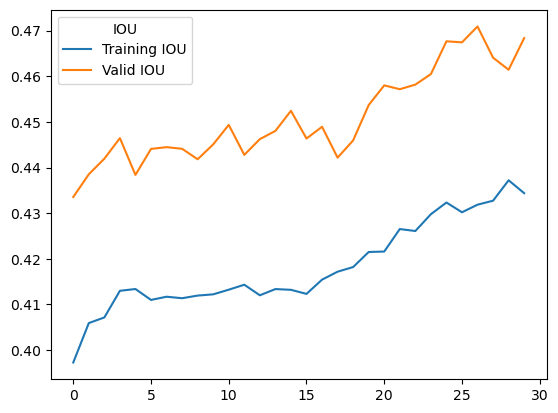

In [15]:
plt.plot(train_iou,label='Training IOU')
plt.plot(test_iou, label='Valid IOU')
plt.legend(loc='upper left', title='IOU');

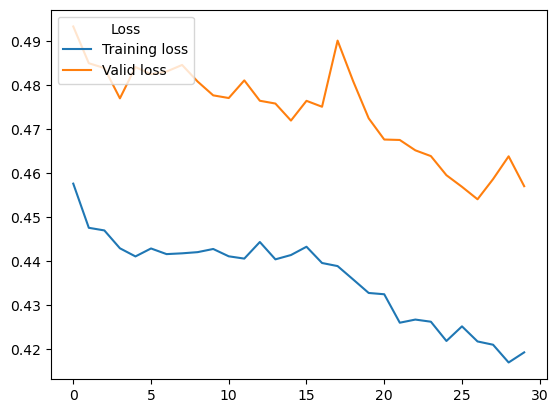

In [16]:
plt.plot(train_loss,label='Training loss')
plt.plot(test_loss, label='Valid loss')
plt.legend(loc='upper left', title='Loss');

In [17]:
vit = get_best_model(vit)

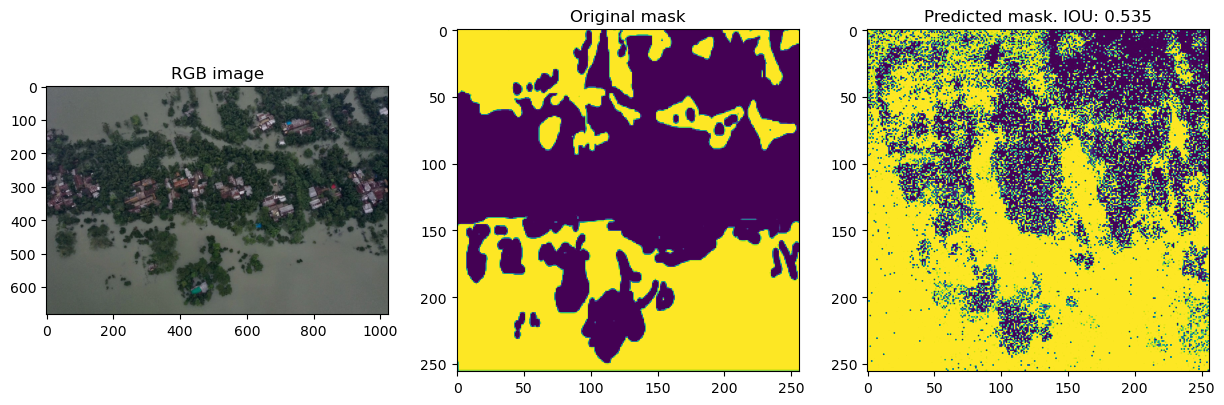

In [21]:
for impath, img, mask in test_dl:
    break
res = vit(img.to(device))
fig, axis = plt.subplots(1, 3, figsize=(15, 17))
orgimg = plt.imread(impath[0])
axis[0].imshow( orgimg)
axis[0].set_title("RGB image")
axis[1].imshow(mask[0].detach().cpu().permute(1, 2,0) )
axis[1].set_title("Original mask")
axis[2].imshow(res[0].detach().cpu().permute(1, 2, 0))
axis[2].set_title(f"Predicted mask. IOU: {round(float(iou(res[0], mask[0].to(device))), 3)}")
# print(res[0].min(), res[0].max(), (mask[0]).min(), (mask[0]).max())
plt.show()

# VIT from scratch

In [87]:

def get_positional_embeddings(sequence_length, d):
    result = torch.ones(sequence_length, d)
    for i in range(sequence_length):
        for j in range(d):
            result[i][j] = np.sin(i / (10000 ** (j / d))) if j % 2 == 0 else np.cos(i / (10000 ** ((j - 1) / d)))
    return result

def patchify(images, n_patches):
    n, c, h, w = images.shape

    assert h == w, "Patchify method is implemented for square images only"

    patches = torch.zeros(n, n_patches ** 2, h * w * c // n_patches ** 2)
    patch_size = h // n_patches

    for idx, image in enumerate(images):
        for i in range(n_patches):
            for j in range(n_patches):
                patch = image[:, i * patch_size: (i + 1) * patch_size, j * patch_size: (j + 1) * patch_size]
                patches[idx, i * n_patches + j] = patch.flatten()
    return patches
class MyMSA(nn.Module):
    def __init__(self, d, n_heads=2):
        super(MyMSA, self).__init__()
        self.d = d
        self.n_heads = n_heads

        assert d % n_heads == 0, f"Can't divide dimension {d} into {n_heads} heads"

        d_head = int(d / n_heads)
        self.q_mappings = nn.ModuleList([nn.Linear(d_head, d_head) for _ in range(self.n_heads)])
        self.k_mappings = nn.ModuleList([nn.Linear(d_head, d_head) for _ in range(self.n_heads)])
        self.v_mappings = nn.ModuleList([nn.Linear(d_head, d_head) for _ in range(self.n_heads)])
        self.d_head = d_head
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, sequences):
        # Sequences has shape (N, seq_length, token_dim)
        # We go into shape    (N, seq_length, n_heads, token_dim / n_heads)
        # And come back to    (N, seq_length, item_dim)  (through concatenation)
        result = []
        for sequence in sequences:
            seq_result = []
            for head in range(self.n_heads):
                q_mapping = self.q_mappings[head]
                k_mapping = self.k_mappings[head]
                v_mapping = self.v_mappings[head]

                seq = sequence[:, head * self.d_head: (head + 1) * self.d_head]
                q, k, v = q_mapping(seq), k_mapping(seq), v_mapping(seq)

                attention = self.softmax(q @ k.T / (self.d_head ** 0.5))
                seq_result.append(attention @ v)
            result.append(torch.hstack(seq_result))
        return torch.cat([torch.unsqueeze(r, dim=0) for r in result])
class MyViTBlock(nn.Module):
    def __init__(self, hidden_d, n_heads, mlp_ratio=4):
        super(MyViTBlock, self).__init__()
        self.hidden_d = hidden_d
        self.n_heads = n_heads

        self.norm1 = nn.LayerNorm(hidden_d)
        self.mhsa = MyMSA(hidden_d, n_heads)
        self.norm2 = nn.LayerNorm(hidden_d)
        self.mlp = nn.Sequential(
            nn.Linear(hidden_d, mlp_ratio * hidden_d),
            nn.GELU(),
            nn.Linear(mlp_ratio * hidden_d, hidden_d)
        )

    def forward(self, x):
        out = x + self.mhsa(self.norm1(x))
        out = out + self.mlp(self.norm2(out))
        return out
class MyViT(nn.Module):
    def __init__(self, chw, n_patches=7, n_blocks=2, hidden_d=8, n_heads=2, out_d=10):
        # Super constructor
        super(MyViT, self).__init__()
        
        # Attributes
        self.chw = chw # ( C , H , W )
        self.n_patches = n_patches
        self.n_blocks = n_blocks
        self.n_heads = n_heads
        self.hidden_d = hidden_d
        
        # Input and patches sizes
        assert chw[1] % n_patches == 0, "Input shape not entirely divisible by number of patches"
        assert chw[2] % n_patches == 0, "Input shape not entirely divisible by number of patches"
        self.patch_size = (chw[1] / n_patches, chw[2] / n_patches)

        # 1) Linear mapper
        self.input_d = int(chw[0] * self.patch_size[0] * self.patch_size[1])
        self.linear_mapper = nn.Linear(self.input_d, self.hidden_d)
        
        # 2) Learnable classification token
        self.class_token = nn.Parameter(torch.rand(1, self.hidden_d))
        
        # 3) Positional embedding
        self.register_buffer('positional_embeddings', get_positional_embeddings(n_patches ** 2 + 1, hidden_d), persistent=False)
        
        # 4) Transformer encoder blocks
        self.blocks = nn.ModuleList([MyViTBlock(hidden_d, n_heads) for _ in range(n_blocks)])
        
        # 5) Classification MLPk
        self.mlp = nn.Sequential(
            nn.Linear(self.hidden_d, IMG_SIZE*IMG_SIZE),
        )
        # self.segment_out = nn.Conv2d(1, 1, kernel_size=3, padding = 1)


    def forward(self, images):
        # Dividing images into patches
        n, c, h, w = images.shape
        patches = patchify(images, self.n_patches).to(self.positional_embeddings.device)
        
        # Running linear layer tokenization
        # Map the vector corresponding to each patch to the hidden size dimension
        tokens = self.linear_mapper(patches)
        
        # Adding classification token to the tokens
        tokens = torch.cat((self.class_token.expand(n, 1, -1), tokens), dim=1)
        
        # Adding positional embedding
        out = tokens + self.positional_embeddings.repeat(n, 1, 1)
        
        # Transformer Blocks
        for block in self.blocks:
            out = block(out)
            
        # Getting the classification token only
        out = out[:, 0]
        out = self.mlp(out)
        mask_logits = out.view(-1, 1, IMG_SIZE, IMG_SIZE)
        
        # Apply softmax activation to generate probabilities
        mask_probs = nn.Sigmoid()(mask_logits)
        return  mask_probs
vit = MyViT((3, 256, 256), n_patches=8, n_blocks=2, hidden_d=8, n_heads=2, out_d=224*224).to(device)

# DeepLab V3 plus

In [68]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class ASPPModule(nn.Module):
    def __init__(self, in_channels, out_channels, dilation_rates):
        super(ASPPModule, self).__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1)
        self.bn1 = nn.BatchNorm2d(out_channels)

        self.conv2 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=dilation_rates[0], dilation=dilation_rates[0])
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.conv3 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=dilation_rates[1], dilation=dilation_rates[1])
        self.bn3 = nn.BatchNorm2d(out_channels)

        self.conv4 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=dilation_rates[2], dilation=dilation_rates[2])
        self.bn4 = nn.BatchNorm2d(out_channels)

        self.conv5 = nn.Conv2d(in_channels, out_channels, kernel_size=1)
        self.bn5 = nn.BatchNorm2d(out_channels)

        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        # Branch 1: 1x1 convolution
        branch1 = self.conv1(x)
        branch1 = self.bn1(branch1)
        branch1 = self.relu(branch1)

        # Branch 2: 3x3 convolution with dilation rate 6
        branch2 = self.conv2(x)
        branch2 = self.bn2(branch2)
        branch2 = self.relu(branch2)

        # Branch 3: 3x3 convolution with dilation rate 12
        branch3 = self.conv3(x)
        branch3 = self.bn3(branch3)
        branch3 = self.relu(branch3)

        # Branch 4: 3x3 convolution with dilation rate 18
        branch4 = self.conv4(x)
        branch4 = self.bn4(branch4)
        branch4 = self.relu(branch4)

        # Branch 5: global average pooling and 1x1 convolution
        branch5 = F.adaptive_avg_pool2d(x, (1, 1))
        branch5 = self.conv5(branch5)
        branch5 = self.bn5(branch5)
        branch5 = self.relu(branch5)
        branch5 = F.interpolate(branch5, size=x.size()[2:], mode='bilinear', align_corners=True)

        # Concatenate branches and return
        output = torch.cat((branch1, branch2, branch3, branch4, branch5), dim=1)
        return output


class DeepLabv3Plus(nn.Module):
    def __init__(self, num_classes):
        super(DeepLabv3Plus, self).__init__()

        self.backbone = nn.Sequential(
            nn.Conv2d(3, 3, kernel_size=1),
            nn.BatchNorm2d(3),
            nn.ReLU(inplace=True),
            nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1))
        self.aspp = ASPPModule(in_channels=128, out_channels=256, dilation_rates=[6, 12, 18])
        self.decoder = nn.Sequential(
              nn.Conv2d(1280, 256, kernel_size=3, padding=1),
              nn.BatchNorm2d(256),
              nn.ReLU(inplace=True),
              nn.Conv2d(256, 256, kernel_size=3, padding=1),
              nn.BatchNorm2d(256),
              nn.ReLU(inplace=True),
              nn.Conv2d(256, num_classes, kernel_size=1)
          )

    def forward(self, x):
          # Backbone
        x = self.backbone(x)

        # ASPP
        x = self.aspp(x)

        # Decoder
        x = self.decoder(x)

        # Upsample to original image size
        x = F.interpolate(x, size=(256, 256), mode='bilinear', align_corners=True)

        return torch.sigmoid(x)


deeplab= DeepLabv3Plus(1)

## Training DeepLabV3 plus model

In [69]:
deeplab, train_loss, test_loss, train_iou, test_iou = train_model(deeplab, train_dl,
                                    test_dl, epochs=num_epochs, loss_fn=loss_fn,  learning_rate=0.001)
accuracies["DeepLabV3+"] = np.max(test_iou)

100%|██████████| 10/10 [00:05<00:00,  1.73it/s]


Epoch:1 train loss: 0.3244899385853818              valid loss: 0.2972038255797492 valid IOU: 0.647416803571913 


100%|██████████| 10/10 [00:05<00:00,  1.72it/s]


Epoch:2 train loss: 0.24960917704983762              valid loss: 0.2535722520616319 valid IOU: 0.7028934790028466 


100%|██████████| 10/10 [00:06<00:00,  1.64it/s]


Epoch:3 train loss: 0.22869463970786647              valid loss: 0.20996515618430245 valid IOU: 0.7592108050982157 


100%|██████████| 10/10 [00:05<00:00,  1.72it/s]


Epoch:4 train loss: 0.2338031326469622              valid loss: 0.2191158268186781 valid IOU: 0.7489250898361206 


100%|██████████| 10/10 [00:05<00:00,  1.75it/s]


Epoch:5 train loss: 0.22179049410318075              valid loss: 0.20660880539152357 valid IOU: 0.7713365819719102 


100%|██████████| 10/10 [00:05<00:00,  1.68it/s]


Epoch:6 train loss: 0.22115477762724223              valid loss: 0.2043137616581387 valid IOU: 0.768891970316569 


100%|██████████| 10/10 [00:05<00:00,  1.71it/s]


Epoch:7 train loss: 0.21641957289294192              valid loss: 0.1959166857931349 valid IOU: 0.7801101671324836 


100%|██████████| 10/10 [00:05<00:00,  1.76it/s]


Epoch:8 train loss: 0.20762556477596886              valid loss: 0.1905405190255907 valid IOU: 0.7902690039740669 


100%|██████████| 10/10 [00:05<00:00,  1.70it/s]


Epoch:9 train loss: 0.20130185233919243              valid loss: 0.19065715869267783 valid IOU: 0.7878009478251139 


100%|██████████| 10/10 [00:05<00:00,  1.74it/s]


Epoch:10 train loss: 0.19924377767663254              valid loss: 0.1815776162677341 valid IOU: 0.804085738129086 


100%|██████████| 10/10 [00:05<00:00,  1.72it/s]


Epoch:11 train loss: 0.20490238384196632              valid loss: 0.19783426655663383 valid IOU: 0.7847245865397983 


100%|██████████| 10/10 [00:06<00:00,  1.65it/s]


Epoch:12 train loss: 0.20729527191111916              valid loss: 0.2221625116136339 valid IOU: 0.7446326745880975 


100%|██████████| 10/10 [00:06<00:00,  1.64it/s]


Epoch:13 train loss: 0.2146620201437097              valid loss: 0.18457057740953234 valid IOU: 0.7980661922030978 


100%|██████████| 10/10 [00:06<00:00,  1.62it/s]


Epoch:14 train loss: 0.1996587750158812              valid loss: 0.17547916703754002 valid IOU: 0.8130152821540833 


100%|██████████| 10/10 [00:06<00:00,  1.65it/s]


Epoch:15 train loss: 0.19236557577785693              valid loss: 0.1952914661831326 valid IOU: 0.784385429488288 


100%|██████████| 10/10 [00:05<00:00,  1.74it/s]


Epoch:16 train loss: 0.18605225964596397              valid loss: 0.15980809926986694 valid IOU: 0.8332982593112521 


100%|██████████| 10/10 [00:05<00:00,  1.74it/s]


Epoch:17 train loss: 0.18472014602861905              valid loss: 0.18152273363537258 valid IOU: 0.8019868532816569 


100%|██████████| 10/10 [00:05<00:00,  1.69it/s]


Epoch:18 train loss: 0.18678089662602074              valid loss: 0.18438346518410575 valid IOU: 0.7960067060258653 


100%|██████████| 10/10 [00:05<00:00,  1.76it/s]


Epoch:19 train loss: 0.19614557216041967              valid loss: 0.17074227995342678 valid IOU: 0.8192952871322632 


100%|██████████| 10/10 [00:05<00:00,  1.74it/s]


Epoch:20 train loss: 0.18021846915546216              valid loss: 0.16248154640197754 valid IOU: 0.8329134384791056 


100%|██████████| 10/10 [00:05<00:00,  1.76it/s]


Epoch:21 train loss: 0.18610060685559324              valid loss: 0.16701933410432604 valid IOU: 0.8225937618149651 


100%|██████████| 10/10 [00:05<00:00,  1.77it/s]


Epoch:22 train loss: 0.1784558139349285              valid loss: 0.1559767789310879 valid IOU: 0.840002715587616 


100%|██████████| 10/10 [00:05<00:00,  1.73it/s]


Epoch:23 train loss: 0.19249313756039269              valid loss: 0.17268066273795235 valid IOU: 0.8146399855613708 


100%|██████████| 10/10 [00:06<00:00,  1.62it/s]


Epoch:24 train loss: 0.18636076701314827              valid loss: 0.17356854014926487 valid IOU: 0.8153537975417243 


100%|██████████| 10/10 [00:05<00:00,  1.68it/s]


Epoch:25 train loss: 0.17147323646043477              valid loss: 0.15019901593526205 valid IOU: 0.8478073411517673 


100%|██████████| 10/10 [00:05<00:00,  1.70it/s]


Epoch:26 train loss: 0.1814422121173457              valid loss: 0.1697123580508762 valid IOU: 0.8257477680842081 


100%|██████████| 10/10 [00:05<00:00,  1.71it/s]


Epoch:27 train loss: 0.17651624271744176              valid loss: 0.1654797593752543 valid IOU: 0.832257416513231 


100%|██████████| 10/10 [00:06<00:00,  1.55it/s]


Epoch:28 train loss: 0.17329491282764234              valid loss: 0.15162513653437296 valid IOU: 0.847178041934967 


100%|██████████| 10/10 [00:05<00:00,  1.70it/s]


Epoch:29 train loss: 0.1671780426251261              valid loss: 0.14890439642800224 valid IOU: 0.8500415947702196 


100%|██████████| 10/10 [00:05<00:00,  1.68it/s]

Epoch:30 train loss: 0.16218112958104988              valid loss: 0.1524558663368225 valid IOU: 0.8449937634997897 


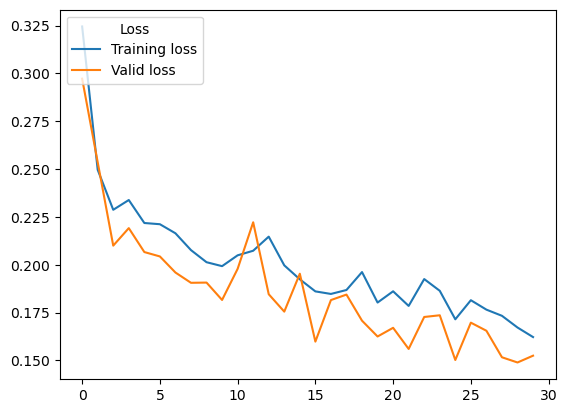

In [70]:
plt.plot(train_loss,label='Training loss')
plt.plot(test_loss, label='Valid loss')
plt.legend(loc='upper left', title='Loss');

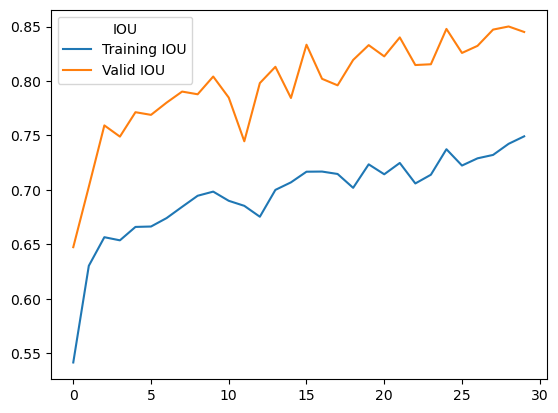

In [71]:
plt.plot(train_iou,label='Training IOU')
plt.plot(test_iou, label='Valid IOU')
plt.legend(loc='upper left', title='IOU');

In [72]:
deelab = get_best_model(deeplab)

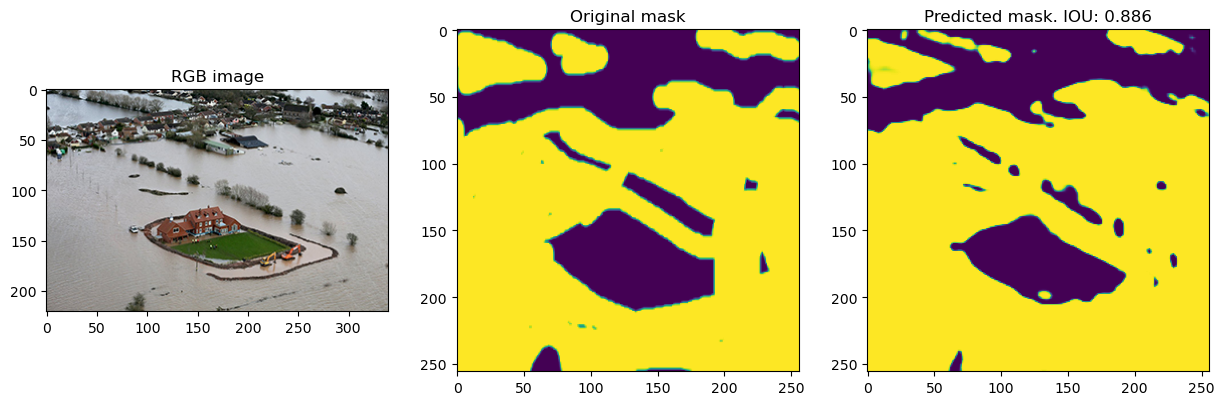

In [78]:
# for impath, img, mask in test_dl:
#     break
# res = deeplab(img.to(device))
fig, axis = plt.subplots(1, 3, figsize=(15, 17))
orgimg = plt.imread(impath[2])
axis[0].imshow( orgimg)
axis[0].set_title("RGB image")
axis[1].imshow(mask[2].detach().cpu().permute(1, 2,0) )
axis[1].set_title("Original mask")
axis[2].imshow(res[2].detach().cpu().permute(1, 2, 0))
axis[2].set_title(f"Predicted mask. IOU: {round(float(iou(res[2], mask[2].to(device))), 3)}")
# print(res[0].min(), res[0].max(), (mask[0]).min(), (mask[0]).max())
plt.show()

# Comparison of models per test accuracies

In [6]:
accuracies={"UNet":0.85951, "U2Net":0.8466, "ReNextUnet":0.95169, "VIT":0.4709, "DeepLabV3+":0.85004}

In [7]:
pd.DataFrame(accuracies.items(), columns=['Model', "Valid Accuracy"]).sort_values("Valid Accuracy", ascending=False)

,Model,Valid Accuracy
2,ReNextUnet,0.95169
0,UNet,0.85951
4,DeepLabV3+,0.85004
1,U2Net,0.84660
3,VIT,0.47090
